In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import re

In [24]:
def create_person_score_df(excel_link):
    '''Creates a df of employee performance metrics based on initial df input'''

    # Extract date from file name
    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    # Read the excel file of initial df
    df = pd.read_excel(excel_link)

    # Create list of unique names
    persons = df['updatedBy'].dropna().unique()

    relevant_status = ['Case Accepted', 'Case with Waiver Accepted']

    df_acc_users = df[df['status'].isin(relevant_status) & df['type']=='New'].copy()
    # Create range of months
    months = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

    # Create a list of all combinations of months and persons
    data = [(month, person) for month in months for person in persons]
    # Create the DataFrame
    person_month_df = pd.DataFrame(data, columns=['Date', 'Employee'])

    # Add the additional columns with zeros
    person_month_df['case_acc_count'] = 0
    person_month_df['case_screen_count'] = 0
    person_month_df['case_create_count'] = 0

    # Add the 'Last Updated' column with the extracted date
    person_month_df['last_updated'] = last_updated

    # Sort the DataFrame by Month and then by Employee
    person_month_df = person_month_df.sort_values(['Date', 'Employee']).reset_index(drop=True)

    # Export as an excel file
    df_acc_users.to_excel('excel_files/case_acc_table.xlsx', index=False)
    person_month_df.to_excel('excel_files/employee_performance_metrics.xlsx', index=False)


In [3]:
def update_acc_info(updated_excel_link):
    '''Takes an updated df excel link, along with the current acceptance df and adds new acceptance info'''

    #Read the excel file of updated DB and acceptance DF
    update_df = pd.read_excel(updated_excel_link)
    acc_df = pd.read_excel('excel_files/case_acc_table.xlsx')

    #Change the date and time to pd datetime
    update_df['updatedDateTime'] = pd.to_datetime(update_df['updatedDateTime'])

    #What statuses we want to check for
    new_relevant_status = ['Case Accepted', 'Case with Waiver Accepted']

    #Create a new df of users updated to relevant statuses
    df_acc_users = update_df[update_df['status'].isin(new_relevant_status)].copy()

    #Iterate over the rows in accepted cases
    for index, row in df_acc_users.iterrows():
        accepted_ID = row['id']
        #Check if the accepted case ID has already been counted
        if accepted_ID not in acc_df['id'].values:
            #It has not already been counted, so we add the row to the accepted df#
            acc_df = pd.concat([acc_df, pd.DataFrame([row])], ignore_index=True)
    acc_df.to_excel('excel_files/case_acc_table.xlsx', index=False)


In [4]:
def month_count_acc(excel_link):
    '''For each person, count the number of cases completed per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_acc_table.xlsx')
    count_df = pd.read_excel('excel_files/employee_performance_metrics.xlsx')

    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    count_df['Date'] = pd.to_datetime(count_df['Date'])

    # Turn date-time column into a pd.datetime element
    df['updatedDateTime'] = pd.to_datetime(df['updatedDateTime'])

    # Create year-month column
    df['year_month'] = df['updatedDateTime'].dt.to_period('M')

    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'updatedBy']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')
    
    # Iterate through the monthly counts and update count_df
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        update_by = row['updatedBy']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        month_date = year_month.to_timestamp()
        
        # Update the count for the specific user and month
        mask = (count_df['Date'] == month_date) & (count_df['Employee'] == update_by) & (count_df['last_updated'] == last_updated)
        count_df.loc[mask, 'case_acc_count'] = count

    #Replace existing file
    count_df.to_excel('excel_files/employee_performance_metrics.xlsx', index=False)


In [5]:
def create_screen_score_df(excel_link):
    '''Creates a df of employee screening 'score' based on initail df input'''

    #Read the excel file of initial df
    df = pd.read_excel(excel_link)

    #Relevant status in this case is Screened cases
    relevant_status = ['Confirmed - False Positive', 'Confirmed - Positive']

    #Create a new df of cases with relevant statuses
    df_screen_users = df[df['status'].isin(relevant_status)].copy()


    df_screen_users.to_excel('excel_files/case_screen_table.xlsx', index=False)


In [6]:
def update_screen_info(updated_excel_link):
    '''Takes an updated df excel link, along with the current screening df and adds new screening info'''

    #Read the excel file of updated DB and screening DF
    update_df = pd.read_excel(updated_excel_link)
    screen_df = pd.read_excel('excel_files/case_screen_table.xlsx')

    #Change the date and time to pd datetime
    update_df['updatedDateTime'] = pd.to_datetime(update_df['updatedDateTime'])

    #What statuses we want to check for
    new_relevant_status = ['Confirmed - Positive', 'Confirmed - False Positive']

    #Create a new df of users updated to relevant statuses
    df_screen_users = update_df[update_df['status'].isin(new_relevant_status)].copy()

    #Iterate over the rows in screened cases
    for index, row in df_screen_users.iterrows():
        screened_ID = row['id']
        #Check if the screened case ID has already been counted
        if screened_ID not in screen_df['id'].values:
            #It has not already been counted, so we add the row to the screened df
            screen_df = pd.concat([screen_df, pd.DataFrame([row])], ignore_index=True)
            
    screen_df.to_excel('excel_files/case_screen_table.xlsx', index=False)


In [7]:
def month_count_screen(excel_link):
    '''For each person, count the number of cases screened per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_screen_table.xlsx')
    count_df = pd.read_excel('excel_files/employee_performance_metrics.xlsx')

    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    count_df['Date'] = pd.to_datetime(count_df['Date'])

    # Turn date-time column into a pd.datetime element
    df['updatedDateTime'] = pd.to_datetime(df['updatedDateTime'])

    # Create year-month column
    df['year_month'] = df['updatedDateTime'].dt.to_period('M')

    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'updatedBy']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')
    
    # Iterate through the monthly counts and update count_df
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        update_by = row['updatedBy']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        month_date = year_month.to_timestamp()
        
        # Update the count for the specific user and month~
        mask = (count_df['Date'] == month_date) & (count_df['Employee'] == update_by) & (count_df['last_updated']==last_updated)
        count_df.loc[mask, 'case_screen_count'] = count
        
    count_df.to_excel('excel_files/employee_performance_metrics.xlsx', index=False)


In [38]:
def create_new_score_df(excel_link):
    '''Creates a df of employee creation 'score' based on initail DB input'''

    #Read the excel file of initial DB
    df = pd.read_excel(excel_link)

    # Extract date from file name
    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    new_df = df[(df['type']=='New') & df['customerInternalID'].notna()].copy()

    #Create list of unique names
    statuses = new_df['status'].dropna().unique()
    risklevels = new_df['riskLevel'].dropna().unique()

    # Create range of months
    months = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

    # Create a list of all combinations of months and persons
    data = [(month, status) for month in months for status in statuses]
    data_risk = [(month, risklevel) for month in months for risklevel in risklevels]
    
    # Create the DataFrame
    status_month_df = pd.DataFrame(data, columns=['Date', 'status'])
    risk_month_df = pd.DataFrame(data_risk, columns = ['Date', 'riskLevel'])
    # Add the additional columns with zeros
    status_month_df['case_count'] = 0
    risk_month_df['case_count'] = 0
    # Add the 'Last Updated' column with the extracted date
    risk_month_df['last_updated'] = last_updated
    status_month_df['last_updated'] = last_updated

    # Sort the DataFrame by Month and then by Employee
    risk_month_df = risk_month_df.sort_values(['Date', 'riskLevel']).reset_index(drop=True)
    status_month_df = status_month_df.sort_values(['Date', 'status']).reset_index(drop=True)


    #Create excel files
    risk_month_df.to_excel('excel_files/case_new_risk.xlsx', index=False)
    status_month_df.to_excel('excel_files/case_new_status.xlsx', index=False)
    new_df.to_excel('excel_files/case_new_table.xlsx', index=False)



In [9]:
def update_new_info(updated_excel_link):
    '''Takes an updated df excel link, and updates the DB of new files'''

    #Read the excel file of updated DB and screening DF
    update_df = pd.read_excel(updated_excel_link)
    new_df = pd.read_excel('excel_files/case_new_table.xlsx')

    #Change the date and time to pd datetime
    update_df['createDateTime'] = pd.to_datetime(update_df['createDateTime'])
    updated_df = update_df[(update_df['type'] == 'New') & (update_df['customerInternalID'].notna())].copy()
    

    #Iterate over the rows in screened cases
    for index, row in updated_df.iterrows():
        ID = row['customerInternalID']
        #Check if the screened case ID has already been counted
        if ID not in new_df['customerInternalID'].values:
            #It has not already been counted, so we add the row to the screened df
            new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)
    new_df.to_excel('excel_files/case_new_table.xlsx', index=False)


In [10]:
def month_count_new(excel_link):
    '''For each person, count the number of cases completed per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_new_table.xlsx')
    count_df = pd.read_excel('excel_files/employee_performance_metrics.xlsx')

    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    count_df['Date'] = pd.to_datetime(count_df['Date'])

    # Turn date-time column into a pd.datetime element
    df['createDateTime'] = pd.to_datetime(df['createDateTime'])

    # Create year-month column
    df['year_month'] = df['createDateTime'].dt.to_period('M')
    
    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'createdBy']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')

    # Iterate through the monthly counts and update count_df
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        create_by = row['createdBy']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        month_date = year_month.to_timestamp()
        
        # Check if the column exists, if not, create it
        
        # Update the count for the specific user and month~
        mask = (count_df['Date'] == month_date) & (count_df['Employee'] == create_by) & (count_df['last_updated']==last_updated)

        count_df.loc[mask, 'case_create_count'] = count

    count_df.to_excel('excel_files/employee_performance_metrics.xlsx', index=False)


In [53]:
def month_count_new_status(excel_link):
    '''For each person, count the number of cases completed per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_new_table.xlsx')
    count_df = pd.read_excel('excel_files/case_new_status.xlsx')

    # Turn date-time column into a pd.datetime element
    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    count_df['Date'] = pd.to_datetime(count_df['Date'])

    # Turn date-time column into a pd.datetime element
    df['createDateTime'] = pd.to_datetime(df['createDateTime'])

    # Create year-month column
    df['year_month'] = df['createDateTime'].dt.to_period('M')
    
    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'status']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')
    # Iterate through the monthly counts and update count_df
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        status = row['status']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        column_date = year_month.to_timestamp()
        
        
        # Update the count for the specific user and month~
        mask = (count_df['Date'] == column_date) & (count_df['status'] == status) & (count_df['last_updated']==last_updated)
        count_df.loc[mask, 'case_count'] = count
        
    count_df.to_excel('excel_files/case_new_status.xlsx', index=False)

In [54]:
def month_count_new_risk(excel_link):
    '''For each person, count the number of cases completed per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_new_table.xlsx')
    count_df = pd.read_excel('excel_files/case_new_risk.xlsx')
    
    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    # Turn date-time column into a pd.datetime element
    df['createDateTime'] = pd.to_datetime(df['createDateTime'])

    # Create year-month column
    df['year_month'] = df['createDateTime'].dt.to_period('M')
    
    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'riskLevel']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')
    # Iterate through the monthly counts and update count_df
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        risk = row['riskLevel']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        column_date = year_month.to_timestamp()
        
        # Update the count for the specific user and month~
        mask = (count_df['Date'] == column_date) & (count_df['riskLevel'] == risk) & (count_df['last_updated']==last_updated)
        count_df.loc[mask, 'case_count'] = count
        

    count_df.to_excel('excel_files/case_new_risk.xlsx', index=False)


In [13]:
def create_SLA_df(excel_link):
    '''Creates a df of internal SLA scores.'''

    #Read the excel file of initial DB
    df = pd.read_excel(excel_link).copy()
    df['TimeToAccept'] = None
    df['SLAscore'] = None
    df.to_excel('excel_files/SLA_scores.xlsx', index=False)


In [66]:
def update_SLA_info(updated_excel_link):
    '''Takes an updated df excel link, along with the current SLA df and updates SLA ratings if there are any changes'''

    #Read the excel file of updated DB and screening DF
    update_df = pd.read_excel(updated_excel_link)
    SLA_df = pd.read_excel('excel_files/SLA_scores.xlsx')

    #Change the date and time to pd datetime
    SLA_df['updatedDateTime'] = pd.to_datetime(SLA_df['updatedDateTime'])
    update_df['updatedDateTime'] = pd.to_datetime(update_df['updatedDateTime'])

    #What statuses we want to check have changed from and to
    old_relevant_status = ['Case Acceptance Required', 'Case with Waiver Acceptance Required']
    new_relevant_status = ['Case Accepted', 'Case with Waiver Accepted']

    df_acc_req_users = SLA_df[SLA_df['status'].isin(old_relevant_status)].copy()
    df_acc_users = update_df[update_df['status'].isin(new_relevant_status)].copy()


    #Create a new df of users which have been updated since the last update
    newly_accepted = df_acc_users[df_acc_users['id'].isin(df_acc_req_users['id'])].copy()
    newly_accepted['updatedDateTime'] = pd.to_datetime(newly_accepted['updatedDateTime'])

    #Iterate through old rows, if the status went from not acceptance required to accepted, the case has been sent for requirement and accepted between updates.
    for index, row in SLA_df.iterrows():
        updated_ID = row['id']
        if SLA_df.loc[SLA_df['id'] == updated_ID, 'status'].iloc[0] not in old_relevant_status:
            if SLA_df.loc[SLA_df['id'] == updated_ID, 'status'].iloc[0] not in new_relevant_status:
                if update_df.loc[update_df['id'] == updated_ID, 'status'].iloc[0] in new_relevant_status:
                    SLA_df.loc[SLA_df['id'] == updated_ID, ['SLAscore', 'TimetoAccept']] = ['Between updates', 'Between Updates']
    
    #Iterate over the rows in updated cases
    for index, row in newly_accepted.iterrows():
        #Check that the row is not a NA, i.e., missing data
        if (not pd.isna(row['updatedDateTime'])):
            updated_ID = row['id']
            #Time of previous update, i.e., time the 'Acceptant Required' was send.
            old_date = SLA_df.loc[SLA_df['id'] == updated_ID, 'updatedDateTime'].iloc[0]
            #Time of most recent update, i.e., time the case was Accepted.
            updated_date = pd.to_datetime(row['updatedDateTime']) 
            time_to_accept = updated_date - old_date
            SLA_df.loc[SLA_df['id'] == updated_ID, 'TimetoAccept'] = str(time_to_accept)
            #Create suitable timedelta objects for comparison
            
            one_month = pd.Timedelta(days=30)
            two_months = pd.Timedelta(days=60)
            three_months = pd.Timedelta(days=90)

            if row['riskLevel']:
                if row['riskLevel'] == 'Low':
                    if old_date + one_month >= updated_date:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Flagged: Low risk but took less than 1 month."
                    else:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Not Flagged"
                elif row['riskLevel'] == 'Standard':
                    if old_date + two_months >= updated_date:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Flagged: Standard risk but took less than 2 months."
                    else:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Not Flagged"
                elif row['riskLevel'] == 'Heightened':
                    if old_date + three_months >= updated_date:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Flagged: Heightened risk but took less than 3 months."
                    else:
                        SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Not Flagged"
            else:
                SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = 'No riskLevel for case.'
            if pd.isna(time_to_accept):
                SLA_df.loc[SLA_df['id'] == updated_ID, 'SLAscore'] = "Missing Data"
            #Update SLA status and updated time
            SLA_df.loc[SLA_df['id'] == updated_ID, 'updatedDateTime'] = newly_accepted['updatedDateTime']
            SLA_df.loc[SLA_df['id'] == updated_ID, 'status'] = newly_accepted['status']
        else:
            SLA_df.loc[SLA_df['id'] == row['id'], 'SLAscore'] = 'Missing Data'
  
    #Iterate over new rows
    for index, row in update_df.iterrows():
        #If it's new, we need to add it to the SLA_df
        if row['id'] not in SLA_df['id'].values:
            #If the case has been accepted, we need to check for missing data, 
            if row['status'] == 'Case Accepted' or row['status'] == 'Case with Waiver Accepted':
                if pd.isna(row['status']) or pd.isna(row['createDateTime']):
                    new_row = row.copy()
                    new_row['SLAscore'] = "Problematic"
                    new_row['TimetoAccept'] = "Missing Data"
                    SLA_df = pd.concat([SLA_df, pd.DataFrame([new_row])], ignore_index=True)
                #If no missing data, then we need to check if it's been added and accepted within a month
                elif pd.to_datetime(row['createDateTime']) >= pd.to_datetime('2024-07-01'):
                    SLA_df = pd.concat([SLA_df, pd.DataFrame([row])], ignore_index=True)
                    SLA_df.loc[SLA_df['id']==row['id'], 'SLAscore'] = "Created between updates"
                    SLA_df.loc[SLA_df['id']==row['id'], 'TimetoAccept'] = "Created Between Updates"
                elif pd.isna(row['createDateTime']):
                    SLA_df = pd.concat([SLA_df, pd.DataFrame([row])], ignore_index=True)
                    SLA_df.loc[SLA_df['id']==row['id'], 'SLAscore'] = "Missing Data"
                    SLA_df.loc[SLA_df['id']==row['id'], 'TimetoAccept'] = "Added Between Updates but no createDateTime"
            #If the status is not relevant, then we just add it
            else:
                SLA_df = pd.concat([SLA_df, pd.DataFrame([row])], ignore_index=True)
        else:
            SLA_df.loc[SLA_df['id'] == row['id'], 'updatedDateTime'] = row['updatedDateTime']
            SLA_df.loc[SLA_df['id'] == row['id'], 'updatedBy'] = row['updatedBy']
            SLA_df.loc[SLA_df['id'] == row['id'], 'status'] = row['status']
            
    SLA_df.to_excel('excel_files/SLA_scores.xlsx', index=False)

In [70]:
def create_new_SLA_df(excel_link):
    '''Creates a df of SLA 'score' based on initail DB input'''

    #Read the excel file of initial DB
    df = pd.read_excel('excel_files/SLA_scores.xlsx')

    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    #Create list of unique names
    scores = df['SLAscore'].dropna().unique()

    #Create range of months
    months = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

    #Create a new df of people against months, with zeroes in entries
    data = [(month, score) for month in months for score in scores]

    score_month_df = pd.DataFrame(data, columns=['Date', 'SLAscore'])

    score_month_df['case_count'] = 0
    
    score_month_df['last_updated'] = last_updated

    score_month_df = score_month_df.sort_values(['Date', 'SLAscore']).reset_index(drop=True)

    score_month_df.to_excel('excel_files/SLA_info.xlsx', index=False)

#Creates a blank table of SLA flagging scores by month

In [69]:
def month_count_SLA(excel_link):
    '''For each person, count the number of SLA scores per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/SLA_scores.xlsx')
    count_df = pd.read_excel('excel_files/SLA_info.xlsx')

    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found
    
    count_df['Date'] = pd.to_datetime(count_df['Date'])

    # Turn date-time column into a pd.datetime element
    df['updatedDateTime'] = pd.to_datetime(df['updatedDateTime'])

    # Create year-month column
    df['year_month'] = df['updatedDateTime'].dt.to_period('M')

    # Count cases per month for each user
    monthly_counts = df.groupby(['year_month', 'SLAscore']).size().reset_index(name='count')

    # Sort by year-month
    monthly_counts = monthly_counts.sort_values('year_month')
    
    # Iterate through the monthly counts and update SLA_info
    for _, row in monthly_counts.iterrows():
        year_month = row['year_month']
        score= row['SLAscore']
        count = row['count']
        
        # Convert year_month to datetime for column indexing
        column_date = year_month.to_timestamp()
        
        # Update the count for the specific user and month
        mask = (count_df['Date'] == column_date) & (count_df['SLAscore'] == score) & (count_df['last_updated']==last_updated)
        count_df.loc[mask, 'case_count'] = count

    count_df.to_excel('excel_files/SLA_info.xlsx', index=False)


#Counts the number of SLA flagged cases per month and updates df

In [68]:
def append_new_rows(excel_link):
    # Read the existing performance metrics file
    count_df = pd.read_excel('excel_files/employee_performance_metrics.xlsx')
    status_df = pd.read_excel('excel_files/case_new_status.xlsx')
    risk_df = pd.read_excel('excel_files/case_new_risk.xlsx')

    # Extract the date from the excel_link filename
    date_match = re.search(r'(\d{8})', excel_link)
    if date_match:
        date_str = date_match.group(1)
        last_updated = pd.to_datetime(date_str, format='%d%m%Y')
    else:
        last_updated = pd.to_datetime('today')  # Use today's date if no match found

    # Convert 'last_updated' column to datetime
    count_df['last_updated'] = pd.to_datetime(count_df['last_updated'])
    status_df['last_updated'] = pd.to_datetime(count_df['last_updated'])
    risk_df['last_updated'] = pd.to_datetime(count_df['last_updated'])

    # Find the most recent date in the existing data
    most_recent_date = count_df['last_updated'].max()
    most_recent_status = status_df['last_updated'].max()
    most_recent_risk = risk_df['last_updated'].max()

    if most_recent_date != last_updated:
        # Filter rows with the most recent date
        most_recent_rows = count_df[count_df['last_updated'] == most_recent_date].copy()

        # Update the 'last_updated' column of these rows to the new last_updated date
        most_recent_rows['last_updated'] = last_updated

        # Concatenate the new rows to the existing DataFrame
        count_df = pd.concat([count_df, most_recent_rows], ignore_index=True)

        # Sort the DataFrame by last_updated (descending) and then by Date (ascending)
        count_df = count_df.sort_values(by=['last_updated', 'Date'], ascending=[False, True])

        # Save the updated DataFrame back to Excel
        count_df.to_excel('excel_files/employee_performance_metrics.xlsx', index=False)
    if most_recent_status != last_updated:
        # Filter rows with the most recent date
        most_recent_rows = status_df[status_df['last_updated'] == most_recent_status].copy()

        # Update the 'last_updated' column of these rows to the new last_updated date
        most_recent_rows['last_updated'] = last_updated

        # Concatenate the new rows to the existing DataFrame
        status_df = pd.concat([status_df, most_recent_rows], ignore_index=True)

        # Sort the DataFrame by last_updated (descending) and then by Date (ascending)
        status_df = status_df.sort_values(by=['last_updated', 'Date'], ascending=[False, True])

        # Save the updated DataFrame back to Excel
        status_df.to_excel('excel_files/case_new_status.xlsx', index=False)
    if most_recent_risk != last_updated:
        # Filter rows with the most recent date
        most_recent_rows = risk_df[risk_df['last_updated'] == most_recent_date].copy()

        # Update the 'last_updated' column of these rows to the new last_updated date
        most_recent_rows['last_updated'] = last_updated

        # Concatenate the new rows to the existing DataFrame
        risk_df = pd.concat([risk_df, most_recent_rows], ignore_index=True)

        # Sort the DataFrame by last_updated (descending) and then by Date (ascending)
        risk_df = risk_df.sort_values(by=['last_updated', 'Date'], ascending=[False, True])

        # Save the updated DataFrame back to Excel
        risk_df.to_excel('excel_files/case_new_risk.xlsx', index=False)



#Appends new rows to metric df, status df, and risk df

In [71]:
def initiation(excel_link):
    """Takes in initial DB and creates tracking excel files"""
    if not os.path.exists('excel_files'):
        os.makedirs('excel_files')
    create_person_score_df(excel_link)
    create_screen_score_df(excel_link)
    create_SLA_df(excel_link)
    create_new_score_df(excel_link)

initiation('tw_prod_cases_01072024.xlsx')

In [73]:
def update_file(excel_link):
    """Inpute an updated excel link and update scores"""
    append_new_rows(excel_link)
    update_acc_info(excel_link)
    month_count_acc(excel_link)
    update_screen_info(excel_link)
    month_count_screen(excel_link)
    update_new_info(excel_link)
    month_count_new(excel_link)
    month_count_new_status(excel_link)
    month_count_new_risk(excel_link)
    update_SLA_info(excel_link)
    create_new_SLA_df(excel_link)
    month_count_SLA(excel_link)
    
update_file('tw_prod_cases_26072024.xlsx')

In [37]:
def month_count(excel_link):

    df = pd.read_excel(excel_link)

    df['updatedDateTime'] = pd.to_datetime(df['updatedDateTime'])

    relevant_status = ['Case Acceptance Required', 'Case with Waiver Acceptance Required']
    df_filtered = df[df['status'].isin(relevant_status)].copy()

    df_filtered['year'] = df_filtered['updatedDateTime'].dt.year
    df_filtered['month'] = df_filtered['updatedDateTime'].dt.month

    monthly_cases = df_filtered.groupby(['year', 'month']).size().reset_index(name='completedCases')
    result = {"monthlyCases": monthly_cases.to_dict('records')}

    monthly_cases.to_excel('excel_files/monthly_count.xlsx', index=False)

month_count('tw_prod_cases_26072024.xlsx')


['2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00', '2024-04-01 00:00:00', '2024-05-01 00:00:00', '2024-06-01 00:00:00', '2024-07-01 00:00:00', '2024-08-01 00:00:00', '2024-09-01 00:00:00', '2024-10-01 00:00:00', '2024-11-01 00:00:00', '2024-12-01 00:00:00']
[0.0, 0.0, 0.0, 14.0, 7.0, 5.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0]


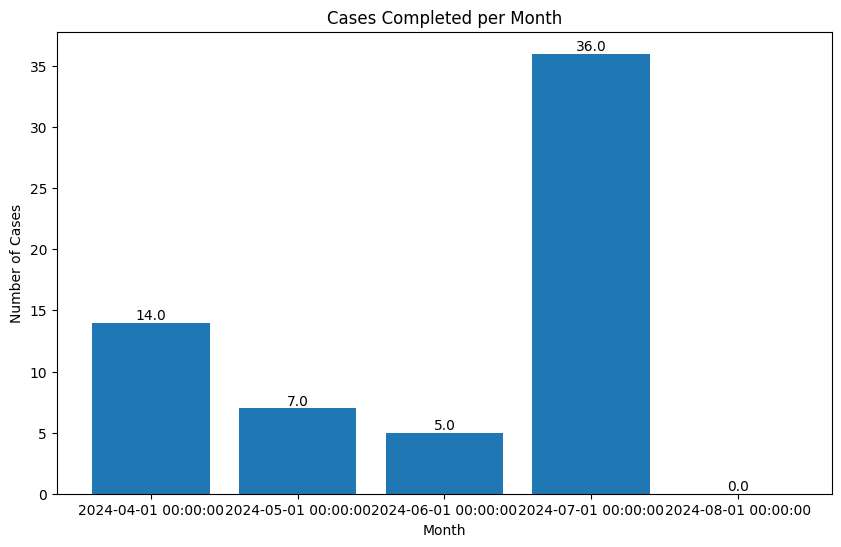

In [38]:
def monthly_count_acc():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel files
    df = pd.read_excel('excel_files/case_acc_info.xlsx')

    month_columns = [col for col in df.columns if col != 'updatedBy']

    if 'Sum' not in df['updatedBy'].values:
        sum_row = pd.DataFrame({'updatedBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)
        for month in month_columns:
            month_sum = df[month].sum()
            df.loc[df['updatedBy'] == 'Sum', month] = month_sum
    
    labels = []
    values = []
    
    
    for month in month_columns:
        values.append(df.loc[df['updatedBy'] == 'Sum', month].iloc[0])
        labels.append(str(month))
    print(labels)
    print(values)

    plt.figure(figsize=(10, 6))
    plt.bar(labels[3:8], values[3:8])

    # Customize the plot
    plt.title('Cases Completed per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Cases')

    # Add value labels on top of each bar
    for i, v in enumerate(values[3:8]):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # Display the plot
    plt.show()
    df.to_excel('excel_files/case_acc_info.xlsx', index=False)
    # Call the function
result = monthly_count_acc()


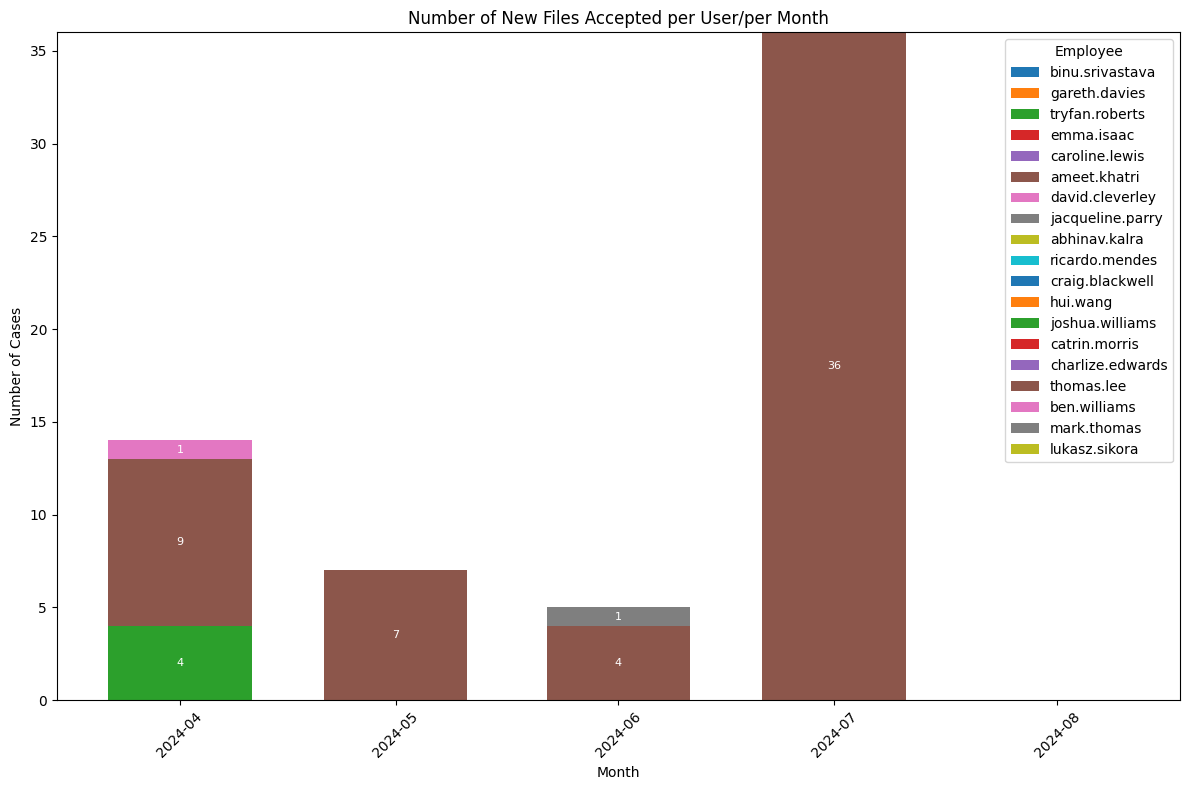

In [39]:
def monthly_count_acc():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_acc_info.xlsx')

    # Get all columns except 'updatedBy'
    month_columns = [col for col in df.columns if col != 'updatedBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['updatedBy'].values:
        sum_row = pd.DataFrame({'updatedBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['updatedBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['updatedBy'] != 'Sum']

    # Prepare the data for plotting
    labels = month_columns[3:8]  # Adjust this slice to match your data range
    employee_names = df_no_sum['updatedBy'].tolist()
    data = df_no_sum[labels].values

    # Create the stacked bar plot with a smaller figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = [0] * len(labels)
    bar_width = 20  # Increase this value to make bars thicker
    for i, employee in enumerate(employee_names):
        bars = ax.bar(labels, data[i], width=bar_width, bottom=bottom, label=employee)
        
        # Add value labels in the center of each bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bottom[j] + height / 2,
                        str(int(height)), ha='center', va='center', color='white', fontsize=8)
        
        bottom = [bottom[j] + data[i][j] for j in range(len(bottom))]

    # Customize the plot
    ax.set_title('Number of New Files Accepted per User/per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Cases')
    ax.legend(title='Employee')

    # Format x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_acc_info.xlsx', index=False)

# Call the function
monthly_count_acc()


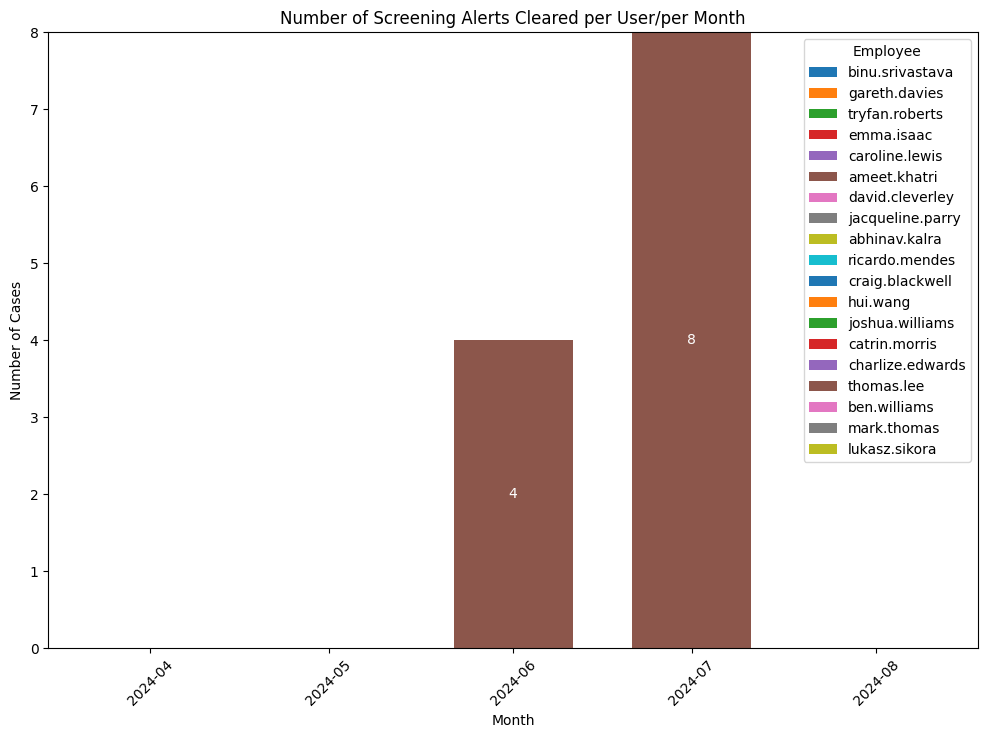

In [40]:
def monthly_count_screen():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_screen_info.xlsx')

    # Get all columns except 'updatedBy'
    month_columns = [col for col in df.columns if col != 'updatedBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['updatedBy'].values:
        sum_row = pd.DataFrame({'updatedBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['updatedBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['updatedBy'] != 'Sum']

    # Prepare the data for plotting
    labels = month_columns[3:8]  # Adjust this slice to match your data range
    employee_names = df_no_sum['updatedBy'].tolist()
    data = df_no_sum[labels].values

    # Create the stacked bar plot with a smaller figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = [0] * len(labels)
    bar_width = 20  # Increase this value to make bars thicker
    for i, employee in enumerate(employee_names):
        ax.bar(labels, data[i], width=bar_width, bottom=bottom, label=employee)
        bottom = [bottom[j] + data[i][j] for j in range(len(bottom))]

    # Customize the plot
    ax.set_title('Number of Screening Alerts Cleared per User/per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Cases')
    ax.legend(title='Employee')

    # Format x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Add value labels on top of each stack
    for i, employee in enumerate(employee_names):
        for j, value in enumerate(data[i]):
            if value > 0:
                ax.text(labels[j], bottom[j] - value / 2, str(int(value)), 
                        ha='center', va='center', color='white')

    # Adjust layout and display

monthly_count_screen()


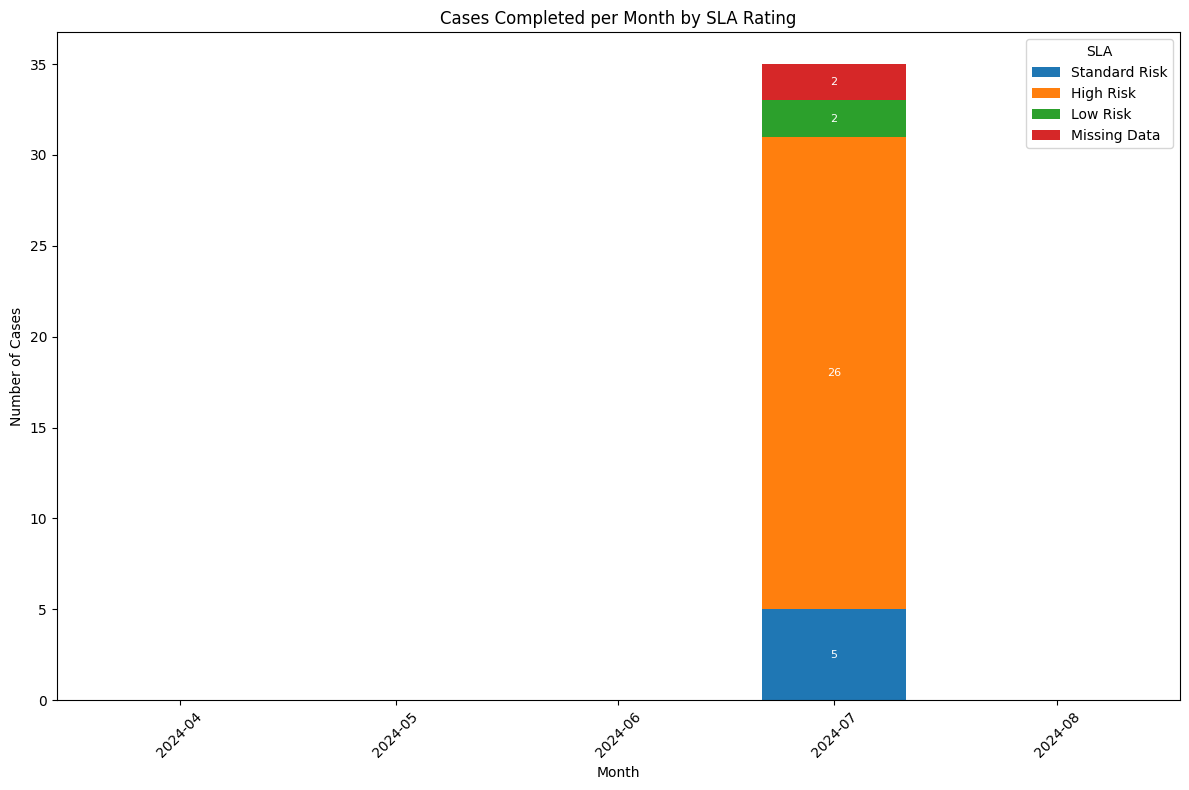

In [41]:
def monthly_count_SLA():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/SLA_info.xlsx')

    # Get all columns except 'updatedBy'
    month_columns = [col for col in df.columns if col != 'SLAscore']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['SLAscore'].values:
        sum_row = pd.DataFrame({'SLAscore': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['SLAscore'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['SLAscore'] != 'Sum']

    # Prepare the data for plotting
    labels = month_columns[3:8]  # Adjust this slice to match your data range
    employee_names = df_no_sum['SLAscore'].tolist()
    data = df_no_sum[labels].values

    # Create the stacked bar plot with a smaller figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = [0] * len(labels)
    bar_width = 20  # Increase this value to make bars thicker
    for i, employee in enumerate(employee_names):
        bars = ax.bar(labels, data[i], width=bar_width, bottom=bottom, label=employee)
        
        # Add value labels in the center of each bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bottom[j] + height / 2,
                        str(int(height)), ha='center', va='center', color='white', fontsize=8)
        
        bottom = [bottom[j] + data[i][j] for j in range(len(bottom))]

    # Customize the plot
    ax.set_title('Cases Completed per Month by SLA Rating')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Cases')
    ax.legend(title='SLA')

    # Format x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/SLA_info.xlsx', index=False)

# Call the function
monthly_count_SLA()


C:\Users\JohnElliott\AppData\Local\Temp\ipykernel_36884\2166256534.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(employee_names))


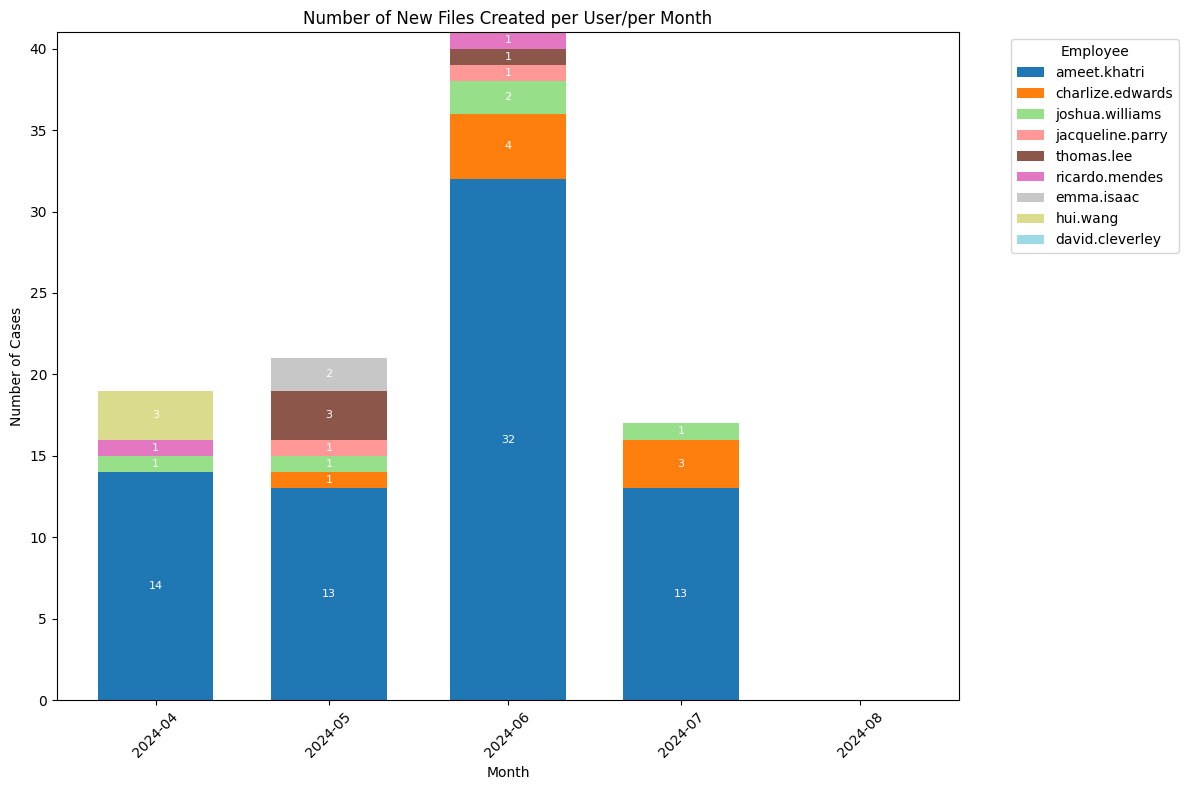

,createdBy,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00
0,ameet.khatri,0.0,0.0,0.0,14.0,13.0,32.0,13.0,0.0,0.0,0.0,0.0,0.0
1,charlize.edwards,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0
2,joshua.williams,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,jacqueline.parry,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,thomas.lee,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ricardo.mendes,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,emma.isaac,0.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,hui.wang,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,david.cleverley,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Sum,0.0,0.0,10.0,19.0,21.0,41.0,17.0,0.0,0.0,0.0,0.0,0.0


In [42]:
import matplotlib.cm as cm

def monthly_count_new():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_info.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'createdBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['createdBy'].values:
        sum_row = pd.DataFrame({'createdBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['createdBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['createdBy'] != 'Sum']

    # Prepare the data for plotting
    labels = month_columns[3:8]  # Adjust this slice to match your data range
    employee_names = df_no_sum['createdBy'].tolist()
    data = df_no_sum[labels].values

    # Create a colormap with enough distinct colors
    colormap = cm.get_cmap('tab20', len(employee_names))

    # Create the stacked bar plot with a smaller figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = [0] * len(labels)
    bar_width = 20  # Increase this value to make bars thicker
    for i, employee in enumerate(employee_names):
        color = colormap(i)
        bars = ax.bar(labels, data[i], width=bar_width, bottom=bottom, label=employee, color=color)
        
        # Add value labels in the center of each bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bottom[j] + height / 2,
                        str(int(height)), ha='center', va='center', color='white', fontsize=8)
        
        bottom = [bottom[j] + data[i][j] for j in range(len(bottom))]

    # Customize the plot
    ax.set_title('Number of New Files Created per User/per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Cases')
    ax.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_info.xlsx', index=False)
    return df

# Call the function
monthly_count_new()


C:\Users\JohnElliott\AppData\Local\Temp\ipykernel_36884\1309398490.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(employee_names))


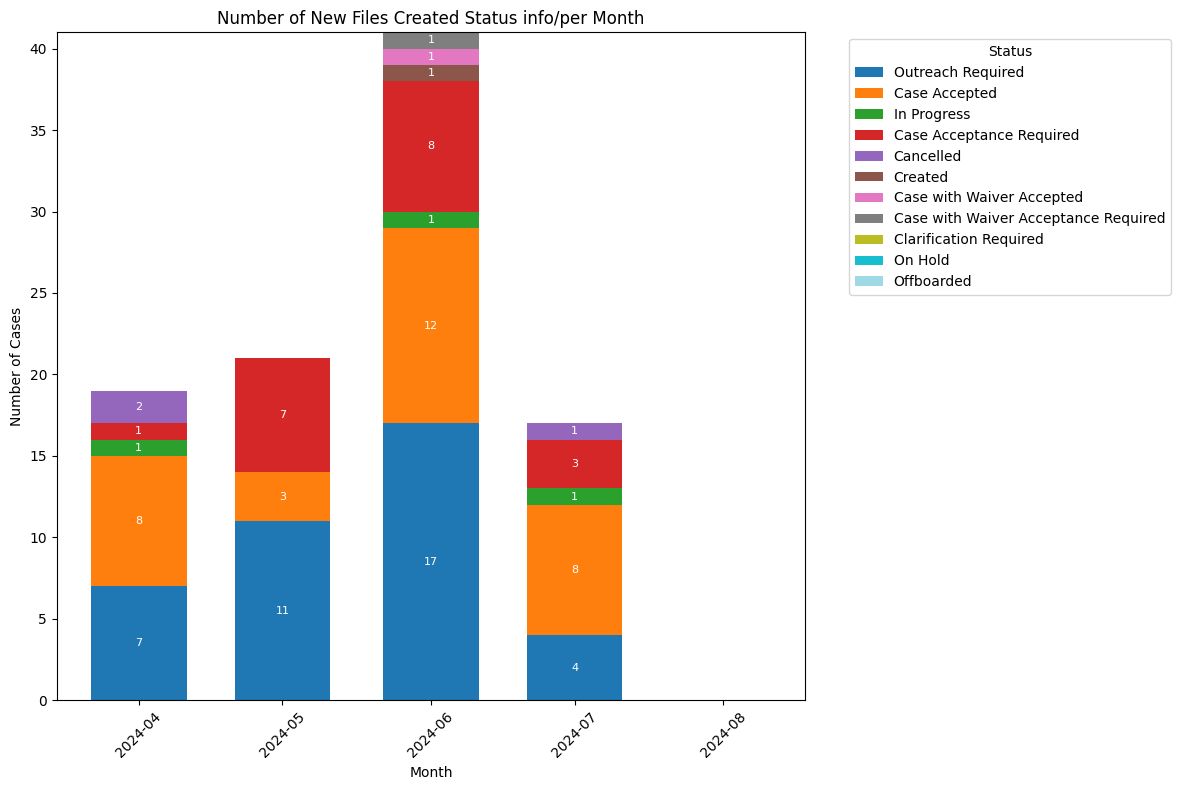

,status,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,...,2024-11-01 00:00:00,2024-12-01 00:00:00,2023-01-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00
0,Outreach Required,0.0,0.0,6.0,7.0,11.0,17.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,5.0,9.0,3.0,0.0,1.0
1,Case Accepted,3.0,0.0,1.0,8.0,3.0,12.0,8.0,0.0,0.0,...,0.0,0.0,1.0,7.0,2.0,10.0,6.0,6.0,4.0,0.0
2,In Progress,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Case Acceptance Required,5.0,0.0,2.0,1.0,7.0,8.0,3.0,0.0,0.0,...,0.0,0.0,4.0,6.0,5.0,6.0,6.0,3.0,6.0,5.0
4,Cancelled,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Created,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Case with Waiver Accepted,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Case with Waiver Acceptance Required,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Clarification Required,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,On Hold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
import matplotlib.cm as cm

def monthly_count_new():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_status.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'status']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['status'].values:
        sum_row = pd.DataFrame({'status': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['status'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['status'] != 'Sum']

    # Prepare the data for plotting
    labels = month_columns[3:8]  # Adjust this slice to match your data range
    employee_names = df_no_sum['status'].tolist()
    data = df_no_sum[labels].values

    # Create a colormap with enough distinct colors
    colormap = cm.get_cmap('tab20', len(employee_names))

    # Create the stacked bar plot with a smaller figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = [0] * len(labels)
    bar_width = 20  # Increase this value to make bars thicker
    for i, employee in enumerate(employee_names):
        color = colormap(i)
        bars = ax.bar(labels, data[i], width=bar_width, bottom=bottom, label=employee, color=color)
        
        # Add value labels in the center of each bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bottom[j] + height / 2,
                        str(int(height)), ha='center', va='center', color='white', fontsize=8)
        
        bottom = [bottom[j] + data[i][j] for j in range(len(bottom))]

    # Customize the plot
    ax.set_title('Number of New Files Created Status info/per Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Cases')
    ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_status.xlsx', index=False)
    return df

# Call the function
monthly_count_new()



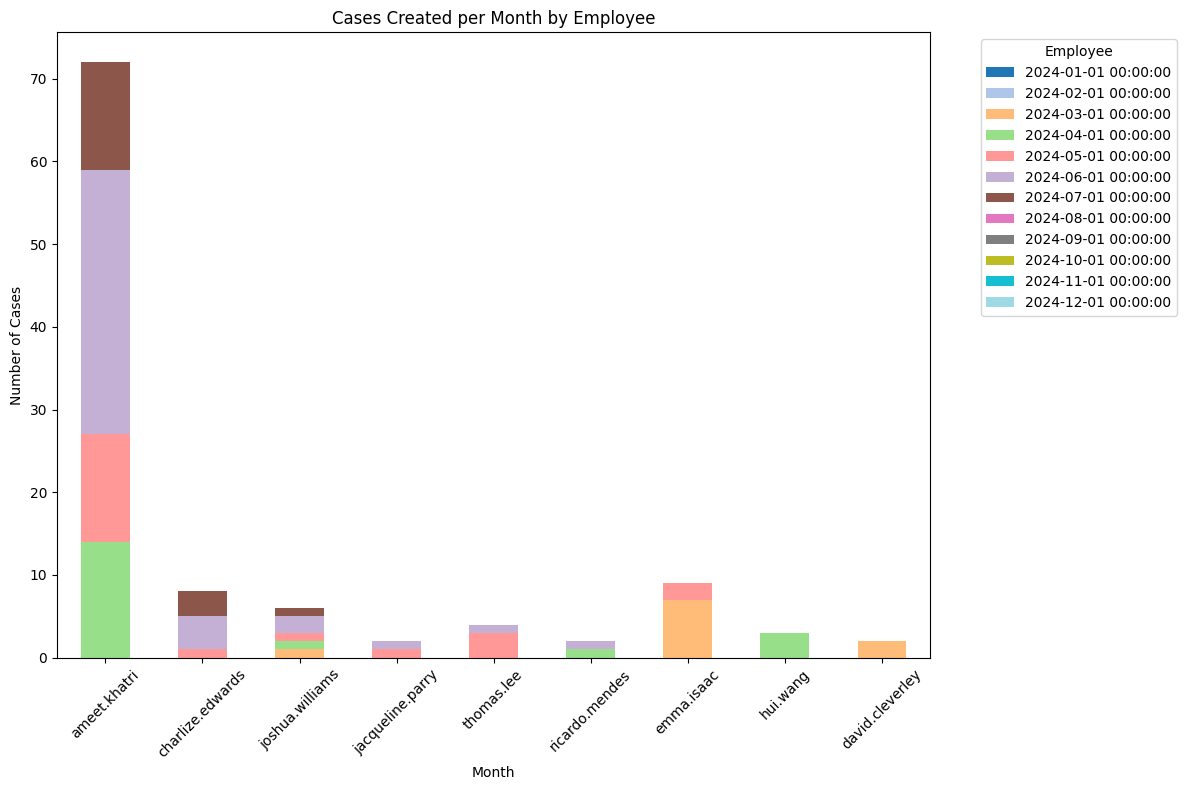

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def monthly_count_new():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_info.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'createdBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['createdBy'].values:
        sum_row = pd.DataFrame({'createdBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['createdBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['createdBy'] != 'Sum']

    # Set 'createdBy' as the index
    df_no_sum.set_index('createdBy', inplace=True)

    # Plot the stacked bar chart using Pandas
    ax = df_no_sum.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

    # Customize the plot
    plt.title('Cases Created per Month by Employee')
    plt.xlabel('Month')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation=45)
    plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_info.xlsx', index=False)

# Call the function
monthly_count_new()

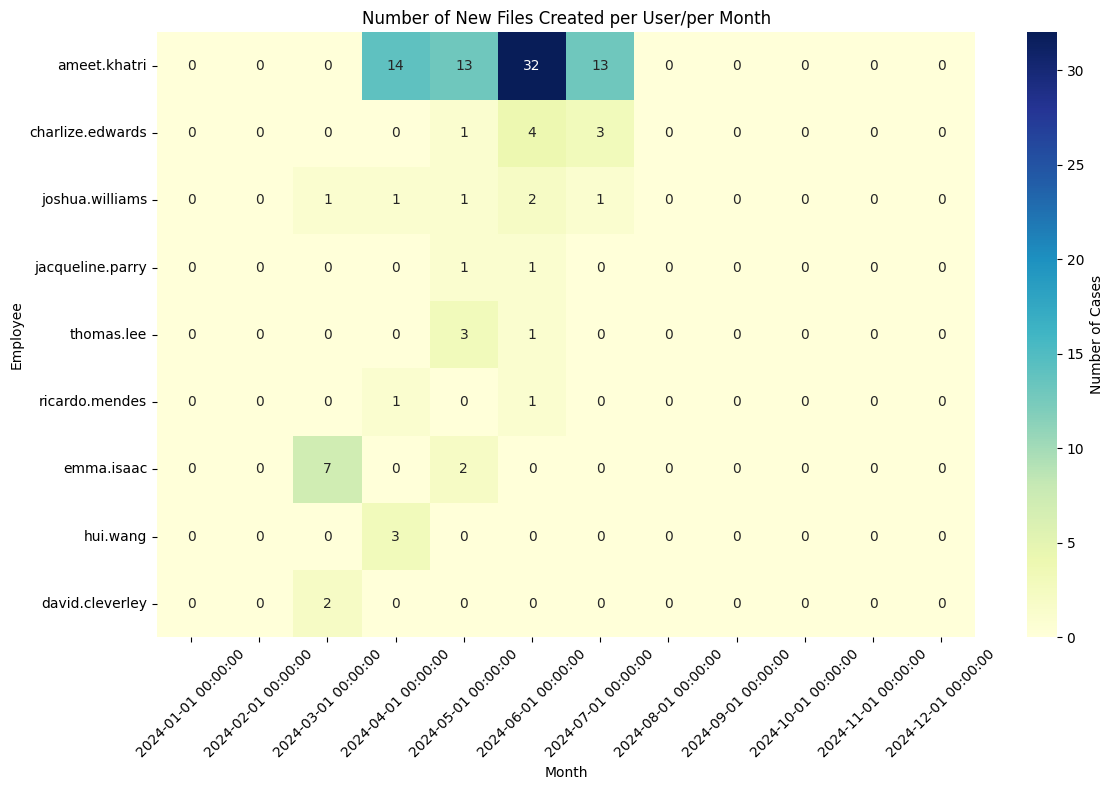

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def monthly_count_new():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_info.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'createdBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['createdBy'].values:
        sum_row = pd.DataFrame({'createdBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['createdBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['createdBy'] != 'Sum']

    # Set 'createdBy' as the index for easier plotting
    df_no_sum.set_index('createdBy', inplace=True)

    # Create a heatmap using Seaborn
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_no_sum[month_columns], annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Cases'})

    # Customize the plot
    plt.title('Number of New Files Created per User/per Month')
    plt.xlabel('Month')
    plt.ylabel('Employee')
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_info.xlsx', index=False)

# Call the function
monthly_count_new()

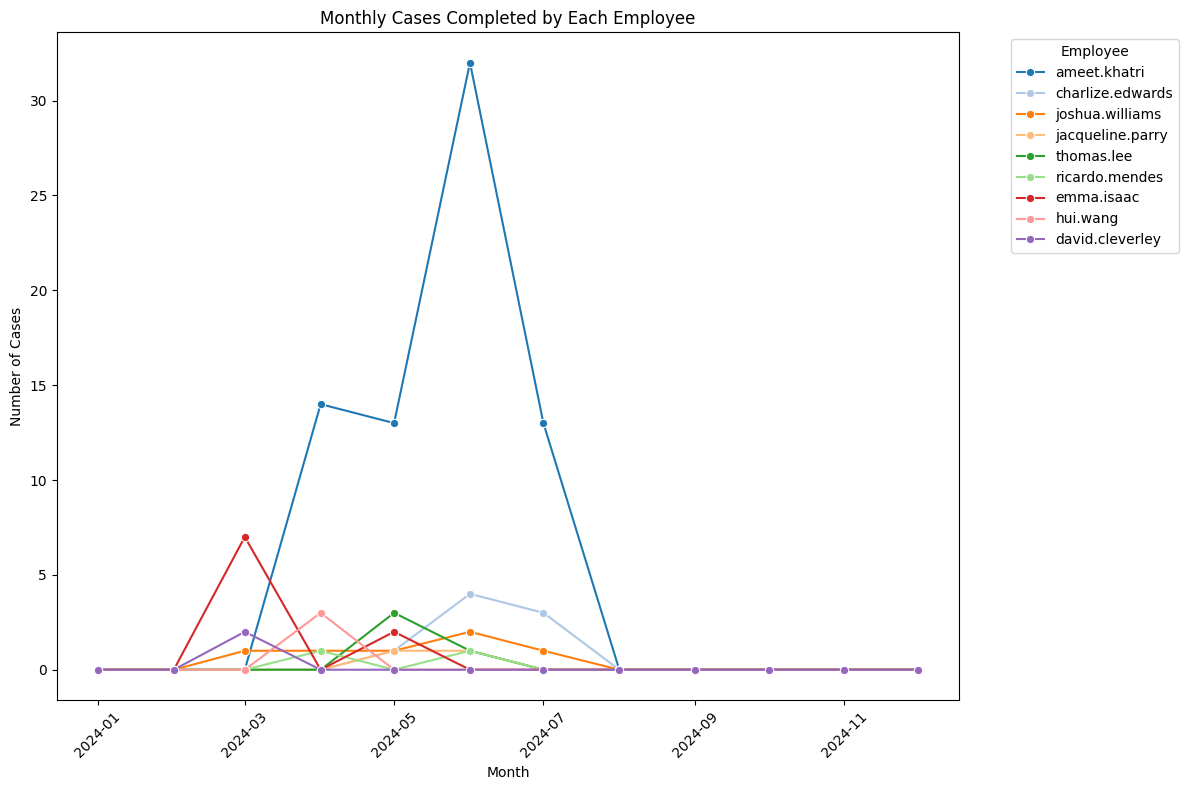

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def monthly_count_new():
    '''For each person, count the number of cases completed per month.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_info.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'createdBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['createdBy'].values:
        sum_row = pd.DataFrame({'createdBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['createdBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['createdBy'] != 'Sum']

    # Melt the DataFrame to long format for Seaborn
    df_melted = df_no_sum.melt(id_vars='createdBy', value_vars=month_columns, var_name='Month', value_name='Cases')

    # Create a line plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_melted, x='Month', y='Cases', hue='createdBy', marker='o', palette='tab20')

    # Customize the plot
    plt.title('Monthly Cases Completed by Each Employee')
    plt.xlabel('Month')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation=45)
    plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_info.xlsx', index=False)

# Call the function
monthly_count_new()

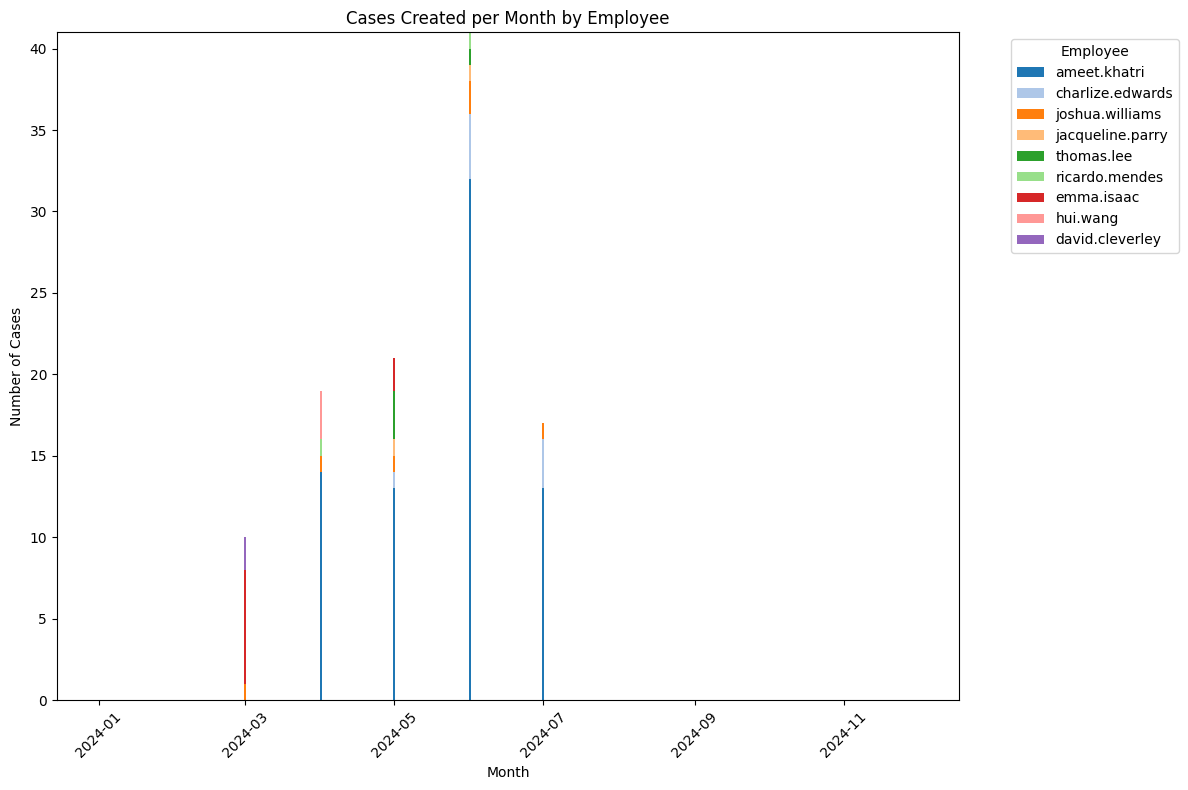

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def monthly_count_new():
    '''For each month, count the number of cases completed by each person.'''

    # Read the excel file
    df = pd.read_excel('excel_files/case_new_info.xlsx')

    # Get all columns except 'createdBy'
    month_columns = [col for col in df.columns if col != 'createdBy']

    # Check if 'Sum' row exists, if not, create it
    if 'Sum' not in df['createdBy'].values:
        sum_row = pd.DataFrame({'createdBy': ['Sum']})
        df = pd.concat([df, sum_row], ignore_index=True)

    # Calculate the sum for each month and update the 'Sum' row
    for month in month_columns:
        month_sum = df[month].sum()
        df.loc[df['createdBy'] == 'Sum', month] = month_sum

    # Drop the 'Sum' row for plotting purposes
    df_no_sum = df[df['createdBy'] != 'Sum']

    # Set 'createdBy' as the index for easier plotting
    df_no_sum.set_index('createdBy', inplace=True)

    # Transpose the DataFrame to have months as the index
    df_transposed = df_no_sum.T

    # Use Seaborn's color palette
    palette = sns.color_palette('tab20', n_colors=len(df_transposed.columns))

    # Create a stacked bar chart using Matplotlib
    plt.figure(figsize=(12, 8))
    bottom = None
    for i, employee in enumerate(df_transposed.columns):
        plt.bar(df_transposed.index, df_transposed[employee], bottom=bottom, label=employee, color=palette[i])
        if bottom is None:
            bottom = df_transposed[employee].copy()
        else:
            bottom += df_transposed[employee]

    # Customize the plot
    plt.title('Cases Created per Month by Employee')
    plt.xlabel('Month')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation=45)
    plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Save the updated DataFrame
    df.to_excel('excel_files/case_new_info.xlsx', index=False)

# Call the function
monthly_count_new()